# Precipitation data

## Pre-process data

To create an example of composite El Niño conditions, download and process some estimates of Southern African precipitation. For this exercise am using the 
[GPCP](https://climatedataguide.ucar.edu/climate-data/gpcp-monthly-global-precipitation-climatology-project]) data set, but only as an example of one of 
[many alternatives](https://climatedataguide.ucar.edu/climate-data/precipitation-data-sets-overview-comparison-table).

### Set environment

In [1]:
#--- Libraries
import matplotlib.pyplot as plt      # plotting package
import seaborn as sns                # plotting aestetics
import netCDF4 as nc                 # package to read NetCDF files
import pandas as pd                  # packages for statistics
import numpy as np                   # packages for linear algebra
import glob                          # command to identify groups of stored files 
import wget                          # packages for accessing online data

from mpl_toolkits.axes_grid1 import ImageGrid       # plot setting libraries
from mpl_toolkits.basemap import Basemap            # map making libraries
from subprocess import call                         # access external OS commands
from cdo import *                                   # access external NetCDF data processing routines
cdo = Cdo()                          

%matplotlib inline

#--- Paths
loc_gpcp = 'ftp://ftp.cdc.noaa.gov/Datasets/gpcp'   # link to NOAA database
var = 'precip.mon.mean'                             # precipitation file
err = 'precip.mon.mean.error'                       # error estimate for precip data

/home/tristan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Create data files

* Download global from the NOAA archive
* Consider only the subregion of Southern Africa 
* For this region create a file of precipitation anomalies from the estimated seasonal rainfall cycle
* See where these anomalies are larger than the esimated error range for the data
* Subset the annomaly data to look only at dates that were previously determined to represent El Niño periods.

In [2]:
#--- Download (global) data
# global precipitation estimate
_ = wget.download(url=loc_gpcp+'/'+var+'.nc',out='data/'+var+'.nc')
# error estimate
_ = wget.download(url=loc_gpcp+'/'+err+'.nc',out='data/'+err+'.nc')

In [3]:
#--- Subset for region
# define region
min_lon =   5 ; max_lon = 55
min_lat = -40 ; max_lat = -5

In [4]:
# create regional files
_ = cdo.sellonlatbox(str(min_lon)+','+str(max_lon)+','+
                     str(min_lat)+','+str(max_lat),
                     input='data/'+var+'.nc',
                     output='data/'+var+'.safr.nc')
_ = cdo.sellonlatbox(str(min_lon)+','+str(max_lon)+','+
                     str(min_lat)+','+str(max_lat),
                     input='data/'+err+'.nc',
                     output='data/'+err+'.safr.nc')

In [5]:
#--- Estimate anomalies from seasonal cycle
# calculate average monthly rainfall 
_ = cdo.ymonmean(input='data/'+var+'.safr.nc',
                 output='data/'+var+'.safr.seascycle.nc')
# find individual differences from expected value
_ = cdo.sub(input='data/'+var+'.safr.nc'+' '+'data/'+var+'.safr.seascycle.nc',
            output='data/'+var+'.safr.anom.nc')

In [6]:
#--- Create a mask for anomalies that are below the error range
# calculate absolute anomalies to check against range
_ = cdo.abs(input='data/'+var+'.safr.anom.nc',
            output='data/'+var+'.safr.abs_anom.nc')
# find where anomaly magnitude is smaller than the estimated error range
_ = cdo.lt(input='data/'+var+'.safr.abs_anom.nc'+' '+'data/'+err+'.safr.nc',
           output='data/mask.abserror.safr.nc')

In [7]:
#--- Identify El Niño periods
# read in dates
mei_elnino_dates = pd.read_pickle('data/mei_elnino_dates.pkl')
# only consider dates in range of precipitation estimate
mei_elnino_dates = mei_elnino_dates[mei_elnino_dates > '1978']
mei_elnino_dates = mei_elnino_dates[mei_elnino_dates < '2015-10-01']
# write out timestamps of selected dates
timestamps = map(lambda x: x.strftime('%Y-%m-%d'), mei_elnino_dates)

In [8]:
#--- Subset data file
# loop over dates
for i in range(len(timestamps)) :
    # select individual field
    _ = cdo.seldate(timestamps[i],
                    input='data/'+var+'.safr.anom.nc',
                    output='data/slice'+('%02d' % i)+'.nc')
    _ = cdo.seldate(timestamps[i],
                    input='data/'+err+'.safr.nc',
                    output='data/err_slice'+('%02d' % i)+'.nc')
    _ = cdo.seldate(timestamps[i],
                    input='data/mask.abserror.safr.nc',
                    output='data/mask_slice'+('%02d' % i)+'.nc')
# merge files
slices = glob.glob('data/slice*.nc')
err_slices = glob.glob('data/err_slice*.nc')
mask_slices = glob.glob('data/mask_slice*.nc')
_ = cdo.mergetime(input=slices,output='data/'+var+'.safr.anom.elnino.nc')
_ = cdo.mergetime(input=err_slices,output='data/'+err+'.safr.elnino.nc')
_ = cdo.mergetime(input=mask_slices,output='data/mask.abserror.safr.elnino.nc')
# sweep up
_ = call('rm '+' '.join(slices),shell=True)
_ = call('rm '+' '.join(err_slices),shell=True)
_ = call('rm '+' '.join(mask_slices),shell=True)

### View examples of data

Create maps of some sample time slices from the El Niño period. 

In [15]:
#--- Arrange data
# load data files
ncfile_anom = nc.Dataset('data/'+var+'.safr.anom.elnino.nc')
ncfile_mask = nc.Dataset('data/mask.abserror.safr.elnino.nc')
# get coordinates of data
lons = ncfile_anom.variables['lon'][:]
lats = ncfile_anom.variables['lat'][:]
# add extra point for grid fill
lons = np.append(lons,lons[-1]+2)
lats = np.append(lats,lats[-1]-2)
# set coordinates list as grid of locations
lons, lats = np.meshgrid(lons,lats)
# shift so that lines show grid box boundaries, 
#    rather than grid point locations
lons = lons - (2/2)
lats = lats + (2/2)
# create list of month names
months = ['January', 'February', 'March', 'April', 
          'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December']

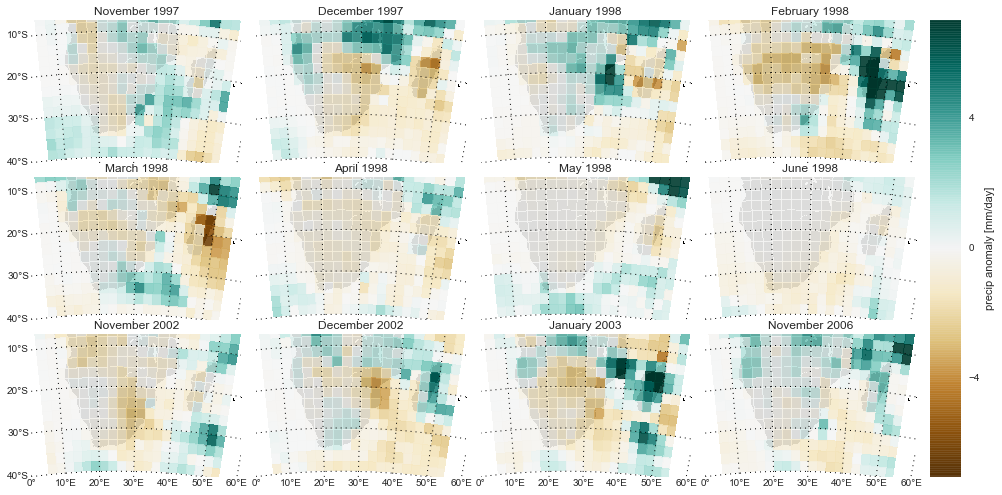

In [16]:
#--- Show some example time slices
# select samples
start = 53 ; stop = start+12
# record dates
sample_dates = cdo.showdate(input='data/'+var+'.safr.anom.elnino.nc')[0].split()[start:stop]
# create date labels
sample_dates = map(lambda x: months[int(x.split('-')[1])-1] +' '+x.split('-')[0], sample_dates)
# initiate counter
c = 0 
# set image
fig = plt.figure(figsize=(22.,18.)) 
plt.figure() 
# divide into a grid, with common color bar
grid_top = ImageGrid(fig, 211, nrows_ncols = (3, 4),
                     cbar_location = "right",
                     cbar_mode="single",
                     cbar_pad=.2,
                     axes_pad=.2) 
# loop over grid elements
for g, node in zip(grid_top,ncfile_anom.variables['precip'][start:stop]):
    # go to current grid element
    plt.sca(g) 
    # set region/projection
    chart = Basemap(projection='lcc',resolution='c',
                    lat_0=-17,lon_0=25,
                    llcrnrlat=-40,urcrnrlat=-5.,
                    llcrnrlon=0,urcrnrlon=55) 
    # mark land mass
    chart.drawlsmask(land_color='black') 
    # draw parallels and meridian on border maps
    if (c == 0 or c == 4) :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,False],dashes=[1,4])
    elif (c == 9 or c == 10 or c == 11) :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[False,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
    elif (c == 8) :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
    else :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[False,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,False],dashes=[1,4])
    # overlay precip anomaly
    sm = chart.pcolormesh(lons,lats,node,shading='flat',latlon=True,
                          alpha=0.9,cmap='BrBG',vmin=-7,vmax=7)

    # label nodes
    #plt.title('['+str(c/4)+', '+str(c%4)+']')
    plt.title(sample_dates[c])
    
    # iterate counter
    c += 1
    
# add color bar 
cb = grid_top.cbar_axes[0].colorbar(sm)
cax = grid_top.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text('precip anomaly [mm/day]')

# save figure
plt.savefig('elnino_samples.png')
